In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import tree
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

# Non-neural models

In [2]:
data = pd.read_csv("./data/full_RASFF_DATA.csv", sep=";", header=0, index_col=0)

data.head(3)

,CLASSIF,DATE_CASE,REF,NOT_COUNTRY,SUBJET,PROD_CAT,TYPE,RISK_DECISION,ACTION_TAKEN,DISTRIBUTION_STAT,PRODUCT,HAZARDS,HAZARDS_CAT,COUNT_ORIGEN,COUNT_DESTIN,COUNT_CONCERN,NUMBER
0,alert,2020-10-16,2020.4364,France,Listeria monocytogenes (presence) in ham trimm...,meat and meat products (other than poultry),food,serious,recall from consumers,distribution to other member countries,ham trimmings,listeria monocytogenes,microbial contaminants (other),France,"Czech Republic,United Kingdom",NaN,NaN
1,border rejection,2020-10-16,2020.4349,Bulgaria,prochloraz (0.696 mg/kg - ppm) in mandarins fr...,fruits and vegetables,food,serious,destruction,product not (yet) placed on the market,mandarins,prochloraz,pesticide residues,Turkey,NaN,Bulgaria,NaN
2,border rejection,2020-10-16,2020.4350,Bulgaria,fenvalerate (0.357 mg/kg - ppm) in chilled man...,fruits and vegetables,food,serious,re-dispatch,product not (yet) placed on the market,chilled mandarins,fenvalerate,pesticide residues,Turkey,NaN,Bulgaria,NaN


In [3]:
train_mask = (data.DATE_CASE >= "2004-01-01") & (data.DATE_CASE <= "2018-12-31")
test_mask = (data.DATE_CASE >= "2019-01-01") & (data.DATE_CASE <= "2019-12-31")

class Stage:
	def __init__(self, input, output):
		self.input = input
		self.output = output

		self.x = data.iloc[:, input]
		self.y = data.iloc[:, output]

		self.x_train, self.x_test, self.y_train, self.y_test = None, None, None, None

		self.classifier = self.Classifier()
		
		self.__transform()

	def __transform(self):
		strategy = OneHotEncoder(handle_unknown="ignore") # One Hot Encoder
		# strategy = OrdinalEncoder() # Integer
		# strategy = FeatureHasher(n_features=25, input_type="string") # Hashing
		# strategy = MultiLabelBinarizer() # Binary

		strategy.fit(self.x.values)

		self.x_train = self.x.loc[train_mask]
		self.y_train = self.y.loc[train_mask]

		self.x_test = self.x.loc[test_mask]
		self.y_test = self.y.loc[test_mask]

		print(self.x_train.shape, self.y_train.shape)
		print(self.x_test.shape, self.y_test.shape)
		
		self.x_train = strategy.transform(self.x_train.values)
		self.x_test = strategy.transform(self.x_test.values)

		# self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(strategy.transform(self.x.values), self.y, test_size=0.2)

	class Classifier:
		pass

## Preprocessing

In [4]:
data.DATE_CASE = data.DATE_CASE.astype(str)
data.HAZARDS_CAT = data.HAZARDS_CAT.astype(str)

data = data[data.HAZARDS.notna()]

In [5]:
data = data.sample(frac=1)

## Transformation

In [6]:
stage1 = Stage(
	# input=[0, 1, 6, 8],
	input=[1, 3, 9, 13],
	output=[5] # Product category
)

stage2 = Stage(
	# input=[0, 1, 2, 6, 8],
	input=[1, 3, 9, 13, 5],
	output=[11] # Hazard category
)

stage3 = Stage(
	# input=[0, 1, 2, 6, 7, 8],
	input=[1, 3, 9, 13, 5, 11],
	output=[8] # Decision taken
)

(47572, 4) (47572, 1)
(4006, 4) (4006, 1)
(47572, 5) (47572, 1)
(4006, 5) (4006, 1)
(47572, 6) (47572, 1)
(4006, 6) (4006, 1)


## Data mining

### Decision trees

In [8]:
class DecisionTree:
	def __init__(self, stage):
		self.stage = stage
		
		self.classifier = tree.DecisionTreeClassifier(criterion="gini")
		self.classifier.fit(stage.x_train, stage.y_train)

		self.y_predict = None

	def predict(self):
		self.y_predict = self.classifier.predict(self.stage.x_test)

	def get_metrics(self):
		print(f"- Accuracy: {round(accuracy_score(self.stage.y_test, self.y_predict)*100, 2)}%")
		print(f"- Specifity: {round(self.classifier.score(self.stage.x_test, self.stage.y_test)*100, 2)}%")
		print(f"- Sensitivity: {round(recall_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
		print(f"- Precision: {round(precision_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
		
		print(classification_report(self.stage.y_test, self.y_predict, zero_division=0))

		cm = confusion_matrix(self.stage.y_test, self.y_predict)
		cm = ConfusionMatrixDisplay(confusion_matrix=cm)

		_, ax = plt.subplots(figsize=(10, 10))
		cm.plot(ax=ax)

In [9]:
stage1.classifier.decision_tree = DecisionTree(stage1)
print("Stage 1 completed")

stage2.classifier.decision_tree = DecisionTree(stage2)
print("Stage 2 completed")	

stage3.classifier.decision_tree = DecisionTree(stage3)
print("Stage 3 completed")

Stage 1 completed
Stage 2 completed
Stage 3 completed


In [10]:
stage1.classifier.decision_tree.predict()
stage2.classifier.decision_tree.predict()
stage3.classifier.decision_tree.predict()

Stage 1
- Accuracy: 45.83%
- Specifity: 45.83%
- Sensitivity: 17.81%
- Precission: 19.38%
                                                   precision    recall  f1-score   support

                              alcoholic beverages       0.00      0.00      0.00        10
                    animal nutrition - (obsolete)       0.00      0.00      0.00         0
            bivalve molluscs and products thereof       0.31      0.43      0.36        84
                 cephalopods and products thereof       0.22      0.14      0.17        28
                      cereals and bakery products       0.18      0.12      0.15       171
     cocoa and cocoa preparations, coffee and tea       0.38      0.07      0.12        70
                                   compound feeds       0.20      0.08      0.11        13
                                    confectionery       0.15      0.07      0.09        61
                 crustaceans and products thereof       0.15      0.13      0.14        55

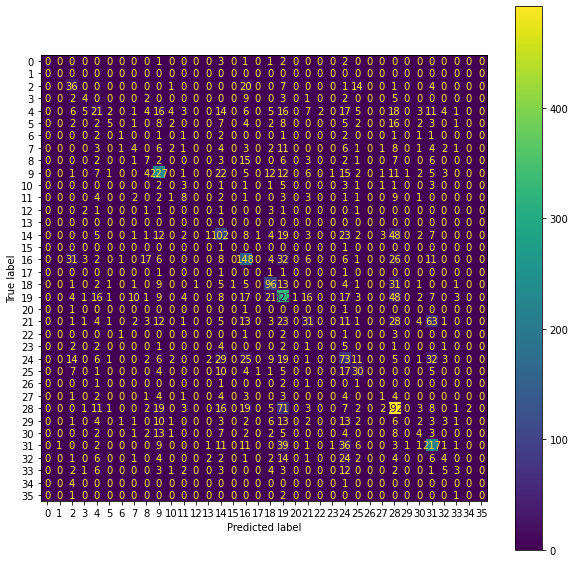

In [11]:
print("Stage 1")
stage1.classifier.decision_tree.get_metrics()

In [12]:
print("Stage 2")
stage2.classifier.decision_tree.get_metrics()

Stage 2
- Accuracy: 31.08%
- Specifity: 31.08%
- Sensitivity: 3.55%
- Precission: 2.79%
                                                                                                                                                                                                                                                                                                                                                              precision    recall  f1-score   support

                                                                                                                                                                                                                                                                                                                                              1,3-pentadiene       0.00      0.00      0.00         0
                                                                                                                                   

In [ ]:
print("Stage 3")
stage3.classifier.decision_tree.get_metrics()

### Boosted trees

In [ ]:
class BoostedTrees:
	def __init__(self, stage):
		self.stage = stage
		
		self.classifier = GradientBoostingClassifier()
		self.classifier.fit(stage.x_train, stage.y_train.values.ravel())

		self.y_predict = None

	def predict(self):
		self.y_predict = self.classifier.predict(self.stage.x_test)

	def get_metrics(self):
		print(f"- Accuracy: {round(accuracy_score(self.stage.y_test, self.y_predict)*100, 2)}%")
		print(f"- Specifity: {round(self.classifier.score(self.stage.x_test, self.stage.y_test)*100, 2)}%")
		print(f"- Sensitivity: {round(recall_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
		print(f"- Precission: {round(precision_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
		
		print(classification_report(self.stage.y_test, self.y_predict, zero_division=0))

		cm = confusion_matrix(self.stage.y_test, self.y_predict)
		cm = ConfusionMatrixDisplay(confusion_matrix=cm)

		_, ax = plt.subplots(figsize=(10, 10))
		cm.plot(ax=ax)

In [ ]:
stage1.classifier.boosted_trees = BoostedTrees(stage1)
print("Stage 1 completed")

stage2.classifier.boosted_trees = BoostedTrees(stage2)
print("Stage 2 completed")

stage3.classifier.boosted_trees = BoostedTrees(stage3)
print("Stage 3 completed")

In [ ]:
stage1.classifier.boosted_trees.predict()
stage2.classifier.boosted_trees.predict()
stage3.classifier.boosted_trees.predict()

In [ ]:
print("Stage 1")
stage1.classifier.boosted_trees.get_metrics()

In [ ]:
print("Stage 2")
stage2.classifier.boosted_trees.get_metrics()

In [ ]:
print("Stage 3")
stage3.classifier.boosted_trees.get_metrics()

### Random Forest

In [ ]:
class RandomForest:
	def __init__(self, stage,params):
		self.stage = stage
		self.params=params
		

		rf = RandomForestClassifier()


		self.classifier = GridSearchCV(estimator = rf, param_grid = self.params, 
                          cv = 3, n_jobs = -1, verbose = 2)
		self.classifier.fit(stage.x_train, stage.y_train)

		self.best_params = self.classifier.best_params_

		self.classifier = RandomForestClassifier(**self.best_params)
		self.classifier.fit(stage.x_train, stage.y_train)

		self.y_predict = None

	def predict(self):
		self.y_predict = self.classifier.predict(self.stage.x_test)

	def get_metrics(self):
		print(f"- Accuracy: {round(accuracy_score(self.stage.y_test, self.y_predict)*100, 2)}%")
		print(f"- Specifity: {round(self.classifier.score(self.stage.x_test, self.stage.y_test)*100, 2)}%")
		print(f"- Sensitivity: {round(recall_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
		print(f"- Precision: {round(precision_score(self.stage.y_test, self.y_predict, average='macro', zero_division=0)*100, 2)}%")
		
		print(classification_report(self.stage.y_test, self.y_predict, zero_division=0))

		cm = confusion_matrix(self.stage.y_test, self.y_predict)
		cm = ConfusionMatrixDisplay(confusion_matrix=cm)

		_, ax = plt.subplots(figsize=(10, 10))
		cm.plot(ax=ax)

In [ ]:
params = {
    'bootstrap': [True],
    'max_depth': [100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [4, 5],
    'min_samples_split': [10, 12],
    'n_estimators': [200, 300, 500]}

stage1.classifier.Random_forest = RandomForest(stage1, params)
print(f"Stage 1 completed: {stage1.classifier.Random_forest.best_params}")

stage2.classifier.Random_forest = RandomForest(stage2, params)
print(f"Stage 2 completed: {stage2.classifier.Random_forest.best_params}")

stage3.classifier.Random_forest = RandomForest(stage3, params)
print(f"Stage 3 completed: {stage3.classifier.Random_forest.best_params}")

In [ ]:
stage1.classifier.Random_forest.predict()
stage2.classifier.Random_forest.predict()
stage3.classifier.Random_forest.predict()

In [ ]:
print("Stage 1")
stage1.classifier.Random_forest.get_metrics()

In [ ]:
print("Stage 2")
stage2.classifier.Random_forest.get_metrics()

In [ ]:
print("Stage 3")
stage3.classifier.Random_forest.get_metrics()